# 0. Imports

In [1]:
import psycopg2                as pg
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt
import scikitplot              as skplt
import warnings 
import random
import pickle
from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn                 import model_selection as ms
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import ExtraTreesClassifier
from catboost                import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import roc_curve, auc
from sklearn.metrics         import roc_auc_score


warnings.filterwarnings('ignore')

## 0.1 Helper function

In [2]:
plt.rcParams['figure.figsize'] = (20,11)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def cross_validation(X_train_, Y_train_, folds, model):
    skfold = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 7)
    
    cross_df = pd.DataFrame(columns = ['Model', 'Folds', 'Precision @ K', 'Recall @ K', 'F1 @ K'])
    
    for mdl in model:
        precision_k = []
        recall_k = []
        f1_k = []
        
        for train_i, val_i in skfold.split(X_train_, Y_train_):
            x_train_fold = X_train_.iloc[train_i]
            y_train_fold = Y_train_.iloc[train_i]
            
            x_test_fold = X_train_.iloc[val_i]
            y_test_fold = Y_train_.iloc[val_i]

            model_ = mdl.fit(x_train_fold, y_train_fold)
            
            y_hat_proba = model_.predict_proba(x_test_fold)
            
            precision_k_score = precision_at_k(x_test_fold, y_test_fold, y_hat_proba, k = 0.3)
            recall_k_score = recall_at_k(x_test_fold, y_test_fold, y_hat_proba, k = 0.3)
            
            precision_k.append(precision_k_score)
            recall_k.append(recall_k_score)
            f1_k.append(2 * ((precision_k_score * recall_k_score) / (precision_k_score + recall_k_score)))
            
        new_row = {'Model': type(mdl).__name__, 
                   'Folds': folds,
                   'Precision @ K': np.mean(precision_k),
                   'Recall @ K': np.mean(recall_k),
                   'F1 @ K': np.mean(f1_k)}
            
        cross_df = cross_df.append(new_row, ignore_index = True)
            
    return cross_df

def precision_at_k(data, y_true, y_proba, k = 0.20):
    
    k = int(data.shape[0] * k)
    
    data['response'] = y_true.copy()
    data['score'] = y_proba[:, 1].tolist()
    
    data = data.sort_values(by = 'score', ascending = False)
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, y_true, y_proba, k = 0.20):
    
    k = int(data.shape[0] * k)
    
    data['response'] = y_true.copy()
    data['score'] = y_proba[:, 1].tolist()
    
    data = data.sort_values(by = 'score', ascending = False)
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

## 0.1.0 Importing and Load dataset

In [3]:
#Credentials 
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'


conn = pg.connect(user = username,
                  password = pwd,
                  host = host,
                  port = port,
                  database = database)

In [4]:
query_tables_users = """
            select *
                    from pa004.users u left join pa004.insurance i on (u.id = i.id)
                    left join pa004.vehicle v   on (u.id = v.id)
            
"""
df1 = pd.read_sql(query_tables_users, conn)



## 0.1.1 Save dataset

In [5]:
df1.to_csv('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/train.csv', index = False)


# 1.0 Data Description

In [6]:
df1 = pd.read_csv('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/train.csv')
df1.head()

,id,gender,age,region_code,policy_sales_channel,id.1,previously_insured,annual_premium,vintage,response,id.2,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.00000,152.00000,7,0,23367.00000,249,0,7,1,< 1 Year,Yes
1,13,Female,41,15.00000,14.00000,13,1,31409.00000,221,0,13,1,1-2 Year,No
2,18,Female,25,35.00000,152.00000,18,1,46622.00000,299,0,18,1,< 1 Year,No
3,31,Female,26,8.00000,160.00000,31,0,2630.00000,136,0,31,1,< 1 Year,No
4,39,Male,45,8.00000,124.00000,39,0,42297.00000,264,0,39,1,1-2 Year,Yes


## 1.1 Data Drop

In [7]:
cols_drop = ['id.1', 'id.2']
df1 = df1.drop(cols_drop, axis = 1)

In [8]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.00000,152.00000,0,23367.00000,249,0,1,< 1 Year,Yes
1,13,Female,41,15.00000,14.00000,1,31409.00000,221,0,1,1-2 Year,No
2,18,Female,25,35.00000,152.00000,1,46622.00000,299,0,1,< 1 Year,No
3,31,Female,26,8.00000,160.00000,0,2630.00000,136,0,1,< 1 Year,No
4,39,Male,45,8.00000,124.00000,0,42297.00000,264,0,1,1-2 Year,Yes


## 1.2 Data Dimensions

In [9]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 381109
Number of columns: 12


## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.5 Descriptive Statistical

### 1.5.1 Numeric Attributes

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license
0,7,23,11.00000,152.00000,0,23367.00000,249,0,1
1,13,41,15.00000,14.00000,1,31409.00000,221,0,1
2,18,25,35.00000,152.00000,1,46622.00000,299,0,1
3,31,26,8.00000,160.00000,0,2630.00000,136,0,1
4,39,45,8.00000,124.00000,0,42297.00000,264,0,1
...,...,...,...,...,...,...,...,...,...
381104,381070,24,8.00000,152.00000,1,38254.00000,127,0,1
381105,381079,58,28.00000,26.00000,0,39740.00000,170,0,1
381106,381082,75,28.00000,26.00000,1,51619.00000,80,0,1
381107,381097,49,10.00000,26.00000,0,34541.00000,44,0,1


In [13]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
m = pd.concat([d1, d2, d3, d4, ct1, ct2, d5, d6]).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m
m.columns = ['Attributes', 'Std', 'min', 'max', 'Range', 'mean', 'median', 'Skew', 'Kurtosis']
m


,Attributes,Std,min,max,Range,mean,median,Skew,Kurtosis
0,id,110016.69187,1.00000,381109.00000,381108.00000,190555.00000,190555.00000,-0.00000,-1.20000
1,age,15.51159,20.00000,85.00000,65.00000,38.82258,36.00000,0.67254,-0.56566
2,region_code,13.22987,0.00000,52.00000,52.00000,26.38881,28.00000,-0.11527,-0.86786
3,policy_sales_channel,54.20392,1.00000,163.00000,162.00000,112.03429,133.00000,-0.90001,-0.97081
4,previously_insured,0.49825,0.00000,1.00000,1.00000,0.45821,0.00000,0.16775,-1.97187
5,annual_premium,17213.13247,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,1.76609,34.00457
6,vintage,83.67119,10.00000,299.00000,289.00000,154.34740,154.00000,0.00303,-1.20069
7,response,0.32794,0.00000,1.00000,1.00000,0.12256,0.00000,2.30191,3.29879
8,driving_license,0.04611,0.00000,1.00000,1.00000,0.99787,1.00000,-21.59518,464.35430


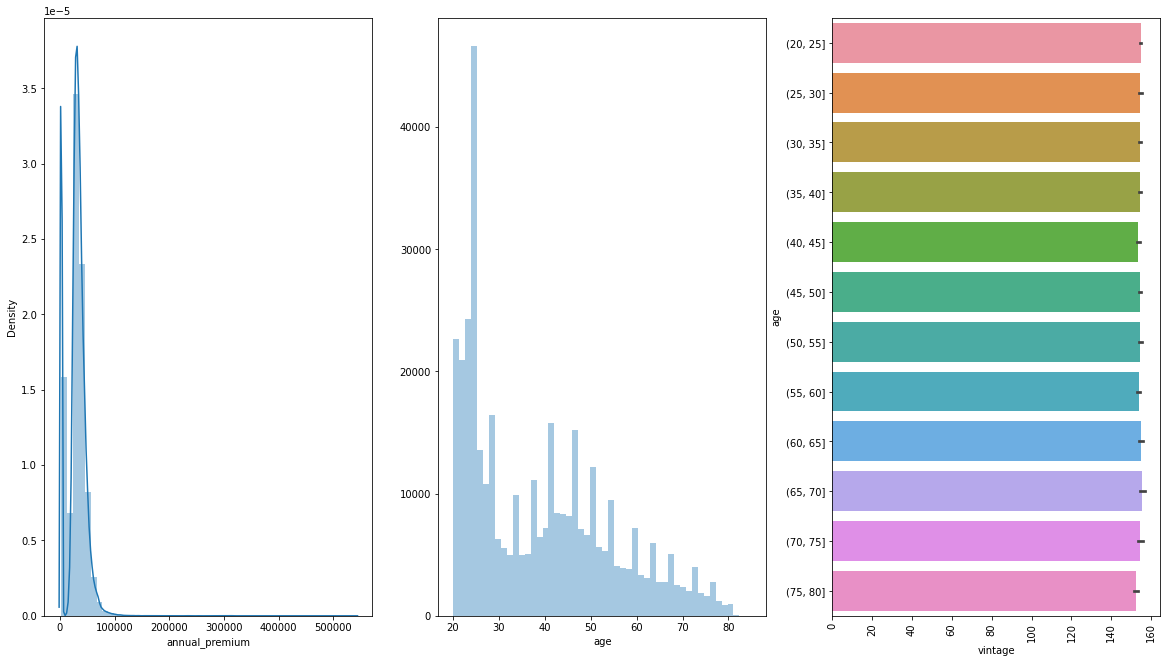

In [14]:
aux1 = df1[['age', 'vintage']].groupby('age').sum().reset_index()


#Insight
plt.subplot(1, 3, 1)
sns.distplot(df1['annual_premium']);

plt.subplot(1, 3, 2)
sns.distplot(df1['age'], kde = False);

#Days of customers has been associated with the company

plt.subplot(1, 3, 3)
bins = list(np.arange(0, 300, 50))
aux1 = df1[['age', 'vintage']].groupby('age').mean().reset_index()
bins = list(np.arange(20, 85, 5))
aux1['age'] = pd.cut(aux1['age'], bins = bins)
sns.barplot(x = 'vintage', y= 'age', data = aux1);
plt.xticks(rotation = 90);

### 1.5.2 Categorical Attributes

In [15]:
cat_attributes

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes
...,...,...,...
381104,Male,< 1 Year,No
381105,Female,1-2 Year,Yes
381106,Female,1-2 Year,No
381107,Female,1-2 Year,Yes


# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
df2.sample(20)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
20375,162642,Male,58,8.00000,124.00000,1,47760.00000,204,0,1,1-2 Year,No
110766,122119,Female,41,39.00000,156.00000,0,2630.00000,160,0,1,1-2 Year,Yes
342057,67483,Male,58,28.00000,26.00000,0,79513.00000,222,0,1,1-2 Year,Yes
13102,105462,Female,30,28.00000,157.00000,0,2630.00000,223,0,1,1-2 Year,Yes
289330,25166,Male,46,39.00000,26.00000,1,45894.00000,98,0,1,1-2 Year,No
23587,188406,Male,30,33.00000,152.00000,0,37405.00000,258,0,1,< 1 Year,Yes
182761,317736,Female,57,28.00000,124.00000,0,47496.00000,213,0,1,1-2 Year,Yes
193609,22447,Female,59,28.00000,18.00000,0,38714.00000,133,0,1,1-2 Year,Yes
268914,243143,Male,21,6.00000,160.00000,1,29135.00000,193,0,1,< 1 Year,No
263070,197384,Female,31,41.00000,152.00000,1,41344.00000,23,0,1,< 1 Year,No


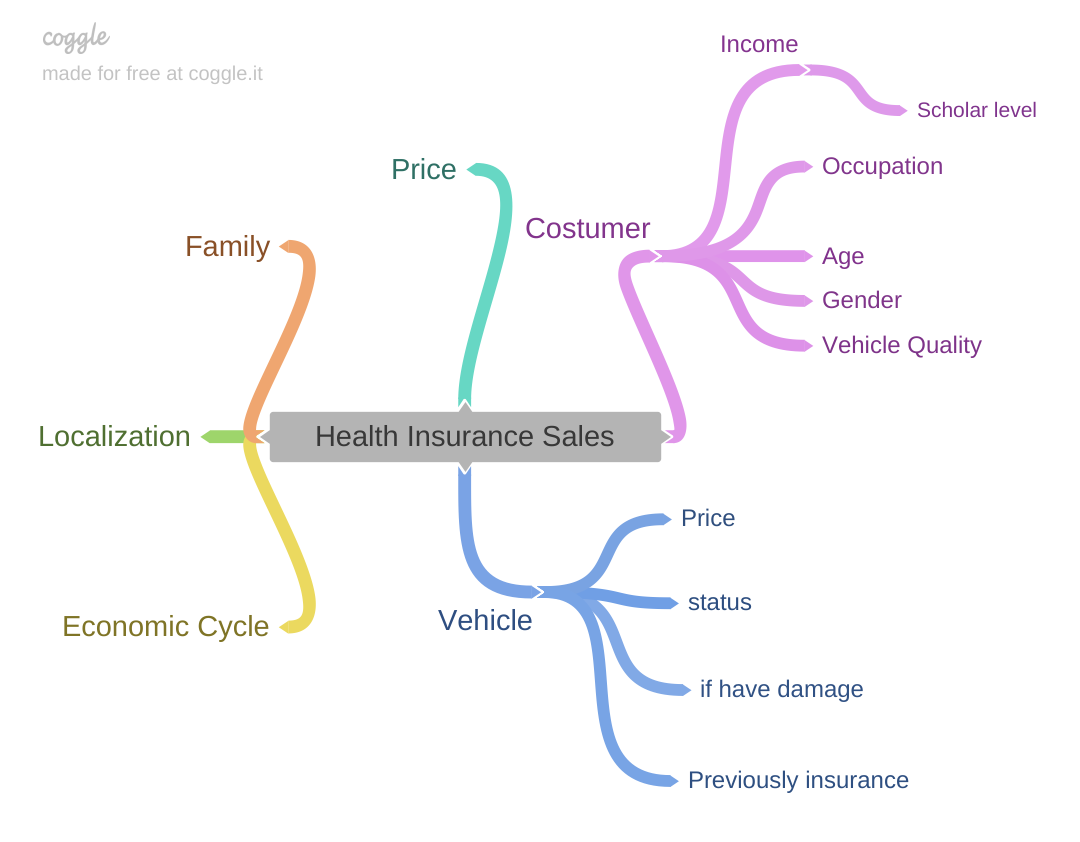

In [131]:
Image('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/Outros/Health_Insurance_Sales.png')

## 2.1 Creating Hypotheses

### 2.1.1 Vehicle's hypothesis

**1**. Vehicles with more damage have more expensive health insurance

**2**. Vehicles with less damage have less expensive health insurance

**3**. Vehicles with previously insurance do not want a new vehicle insurance

**4**. Vehicles with high price have more expensive vehicle insurance

**5**. Vehicles with low price have cheap vehicle insurance

**6**. Vehicles that suffered damage before having more chances to get a vehicle insurance

### 2.1.2 Customer's hypothesis

**1**. Customers with more income probably want health insurance

**2**. Younger customers have cheap health insurance

**3**. Older customers have more expensive health insurance

**5**. Men's customers have health insurance more expensive

**6**. Customers that have more education tends to pay more for health insurance

**7** Customers that pay more for health insurance also pay more for vehicle insurance

**8.** Younger customers don't want vehicles insurance

### 2.1.3 The hypothesis that will be tested

**1**. Vehicles with previously insurance do not want a new vehicle insurance

**2** Damaged vehicles have higher annual premium 

**3.** Younger customers don't want vehicles insurance (> 30 years old)

**4.** Customers with older cars are less likely to want the insurance

**5.** Women are most likely to want a vehicle insurance

**6.** People with +40k annual premium should want the insurance

**7**. Vehicles that suffered damage before having more chances to get a vehicle insurance

## 2.2 New features

In [19]:
#Vehicle damage: Yes = 1; No = 0
new_vehicle_damage = {'Yes': 1, 
                      'No' : 0}

#replace
df2['vehicle_damage'] = df2['vehicle_damage'].map(new_vehicle_damage)

#Gender; Female = 1, Male = 0
gender = {'Male': 0,
          'Female': 1}
df2['gender'] = df2['gender'].map(gender)





In [20]:
# Annual_premium per age
df2['anual_premium_per_age'] = df2['annual_premium'] / df2['age']

#Annual_premium per insurance day

df2['premium_per_day'] = df2['annual_premium'] / df2['vintage']


#vehicle_age: Droping the words "<" and "Year" and replacing < 1 year as 1 year and 1-2 year as 2
vehicle_age = {'< 1 Year': 1,
               '1-2 Year': 2,
                '> 2 Years': 3}
df2['vehicle_age'] = df2['vehicle_age'].map(vehicle_age)



In [21]:
df2.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
policy_sales_channel     0
previously_insured       0
annual_premium           0
vintage                  0
response                 0
driving_license          0
vehicle_age              0
vehicle_damage           0
anual_premium_per_age    0
premium_per_day          0
dtype: int64

# 3.0 Data Filtering

In [22]:
df3 = df2.copy()

In [23]:
df3.head(20)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage,anual_premium_per_age,premium_per_day
0,7,0,23,11.00000,152.00000,0,23367.00000,249,0,1,1,1,1015.95652,93.84337
1,13,1,41,15.00000,14.00000,1,31409.00000,221,0,1,2,0,766.07317,142.12217
2,18,1,25,35.00000,152.00000,1,46622.00000,299,0,1,1,0,1864.88000,155.92642
3,31,1,26,8.00000,160.00000,0,2630.00000,136,0,1,1,0,101.15385,19.33824
4,39,0,45,8.00000,124.00000,0,42297.00000,264,0,1,2,1,939.93333,160.21591
5,55,1,44,28.00000,13.00000,0,45415.00000,73,0,1,2,1,1032.15909,622.12329
6,73,1,23,39.00000,152.00000,1,40372.00000,242,0,1,1,0,1755.30435,166.82645
7,79,0,29,28.00000,26.00000,0,42567.00000,167,1,1,2,1,1467.82759,254.89222
8,95,1,23,15.00000,152.00000,0,41641.00000,209,0,1,1,1,1810.47826,199.23923
9,108,0,31,29.00000,124.00000,0,28867.00000,247,0,1,2,1,931.19355,116.87045


# 4.0 EDA

In [24]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1. Numerical Variables

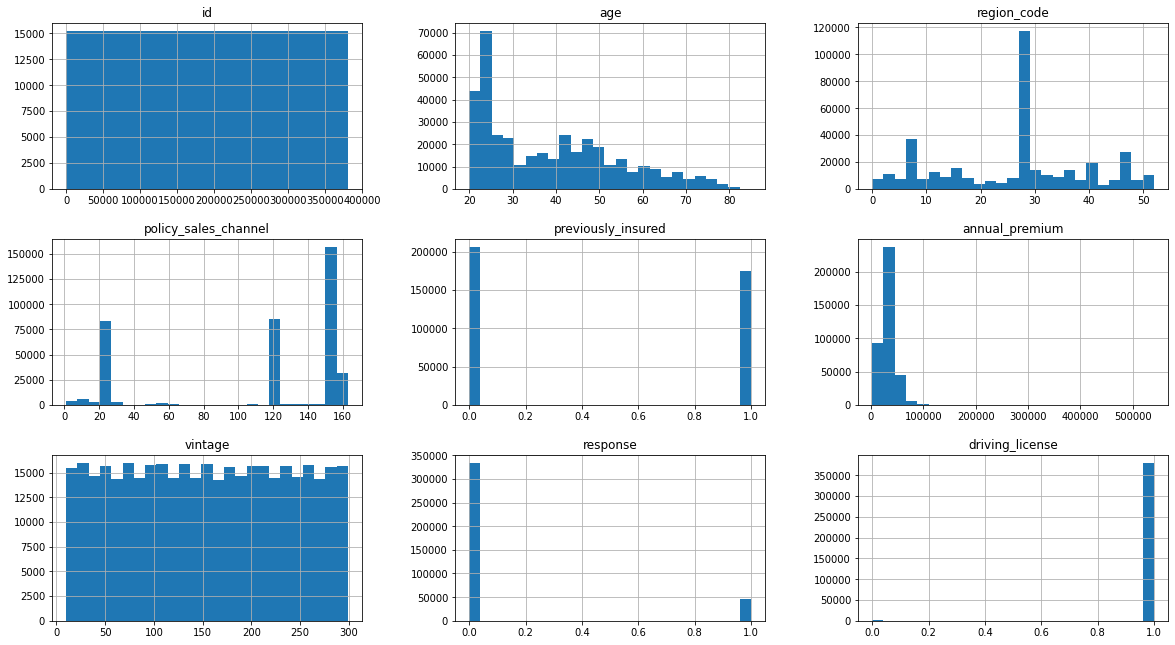

In [25]:
num_attributes.hist(bins = 25);

### 4.1.2 Categorical Attributes

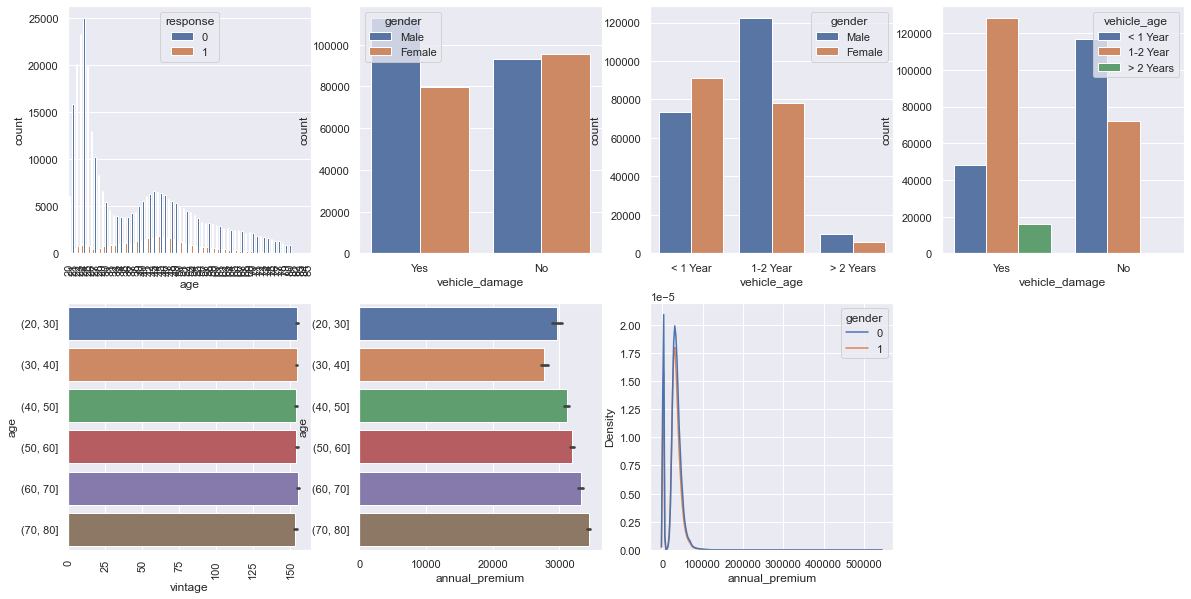

In [26]:
plt.figure(figsize=(20,10))
sns.set_theme()

plt.subplot(2, 4, 1)
sns.countplot(x='age', data = df3, hue = 'response');
plt.xticks(rotation = 90);

#Vehicle status per gender
aux1 = df3[['gender', 'vehicle_damage']].groupby('gender').count().reset_index()
aux1.columns=['gender', 'count_of_vehicle_damage']
plt.subplot(2, 4, 2)
sns.countplot(x = 'vehicle_damage', hue = 'gender', data = cat_attributes);

#Vehicle age per gender
plt.subplot(2,4,3)
sns.countplot(x = 'vehicle_age', hue = 'gender', data = cat_attributes);

#Vehicle damage por vehicle age
plt.subplot(2,4,4)
sns.countplot(x = 'vehicle_damage', hue = 'vehicle_age', data = cat_attributes);

#Vintage per age
plt.subplot(2,4,5)
bins = list(np.arange(0, 300, 50))
aux1 = df1[['age', 'vintage']].groupby('age').mean().reset_index()
bins = list(np.arange(20, 85, 10))
aux1['age'] = pd.cut(aux1['age'], bins = bins)
sns.barplot(x = 'vintage', y= 'age', data = aux1);
plt.xticks(rotation = 90);

#Previously insurance
plt.subplot(2,4,6)
sns.set_theme()
aux1 = df1[['age', 'annual_premium']].groupby('age').mean().reset_index()
bins = list(np.arange(20, 85, 10))
aux1['age'] = pd.cut(aux1['age'], bins = bins)
sns.barplot(x = 'annual_premium', y= 'age', data = aux1);

#annual_premium
plt.subplot(2,4,7)
sns.kdeplot(x = 'annual_premium', hue = 'gender', data = df4);

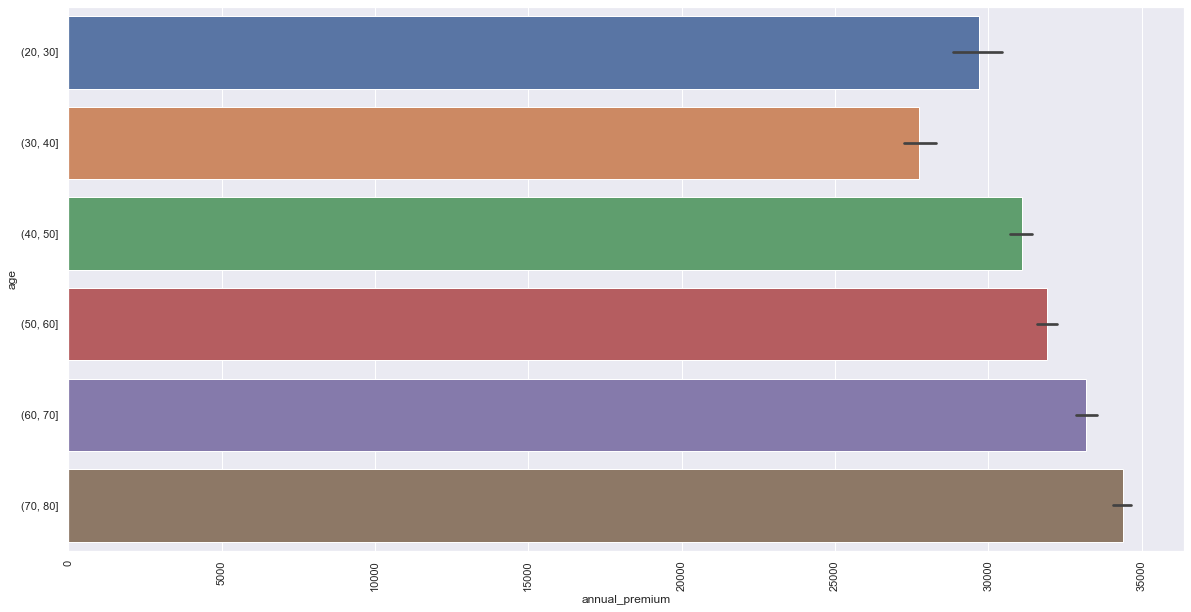

In [27]:
plt.figure(figsize = (20,10))
sns.set_theme()
bins = list(np.arange(0, 300, 50))
aux1 = df1[['age', 'annual_premium']].groupby('age').mean().reset_index()
bins = list(np.arange(20, 85, 10))
aux1['age'] = pd.cut(aux1['age'], bins = bins)
sns.barplot(x = 'annual_premium', y= 'age', data = aux1);
plt.xticks(rotation = 90);

## 4.2 Bivariate Analysis

### 1. Vehicles with previously insurance do not want a new vehicle insurance - True;

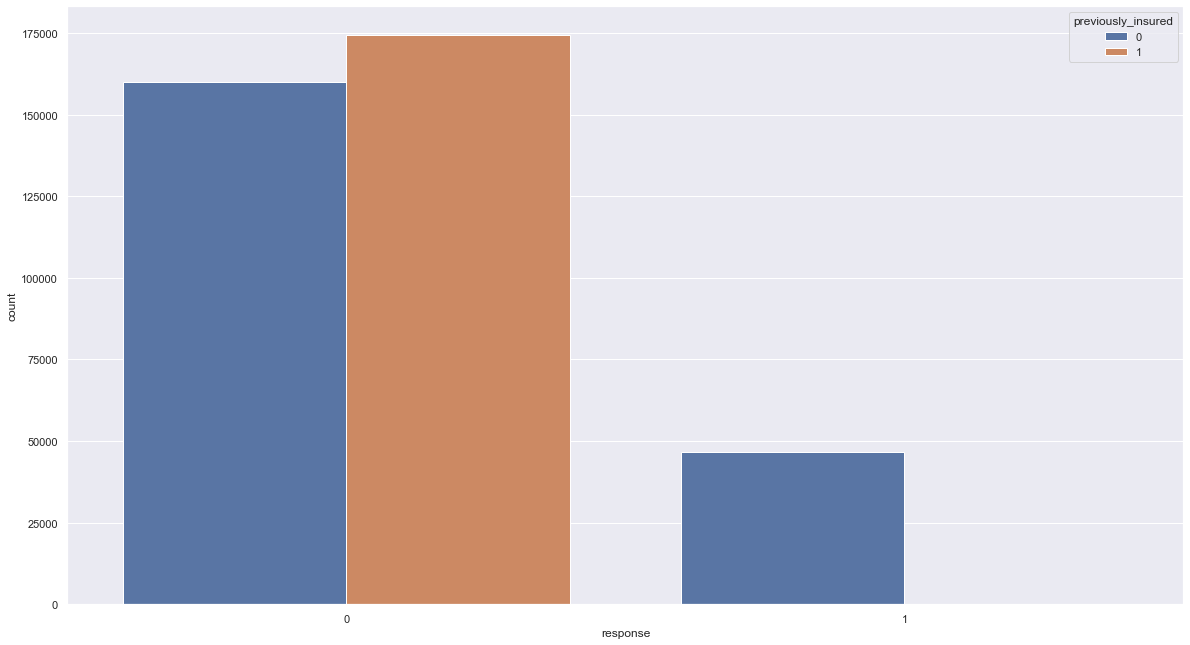

In [28]:
sns.countplot(x = 'response', hue = 'previously_insured', data = df4);

### 2. Damaged vehicles have higher annual premium - True

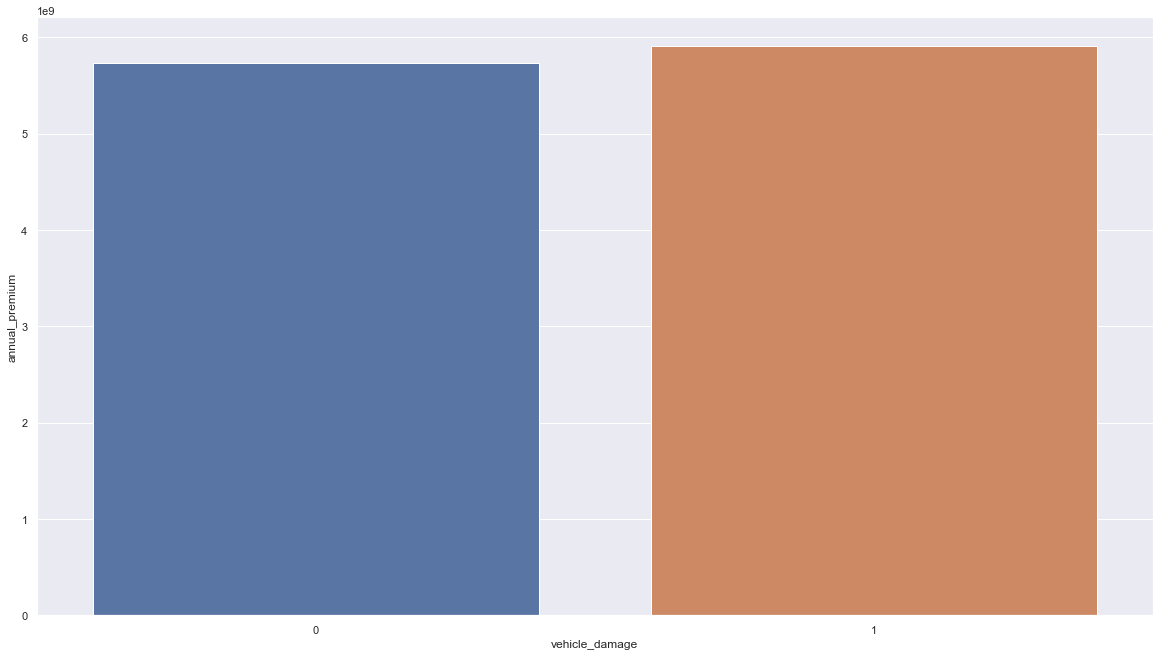

In [29]:
aux1 = df4[['annual_premium', 'vehicle_damage']].groupby('vehicle_damage').sum().reset_index()
plt.yscale('linear')
sns.barplot(x = 'vehicle_damage', y = 'annual_premium', data = aux1);

### 3. Younger customers don't want vehicles insurance (< 30 years old) - True

In [30]:
aux1 = df4[df4['age']<=30]
aux2 = df4[df4['age'] > 30]

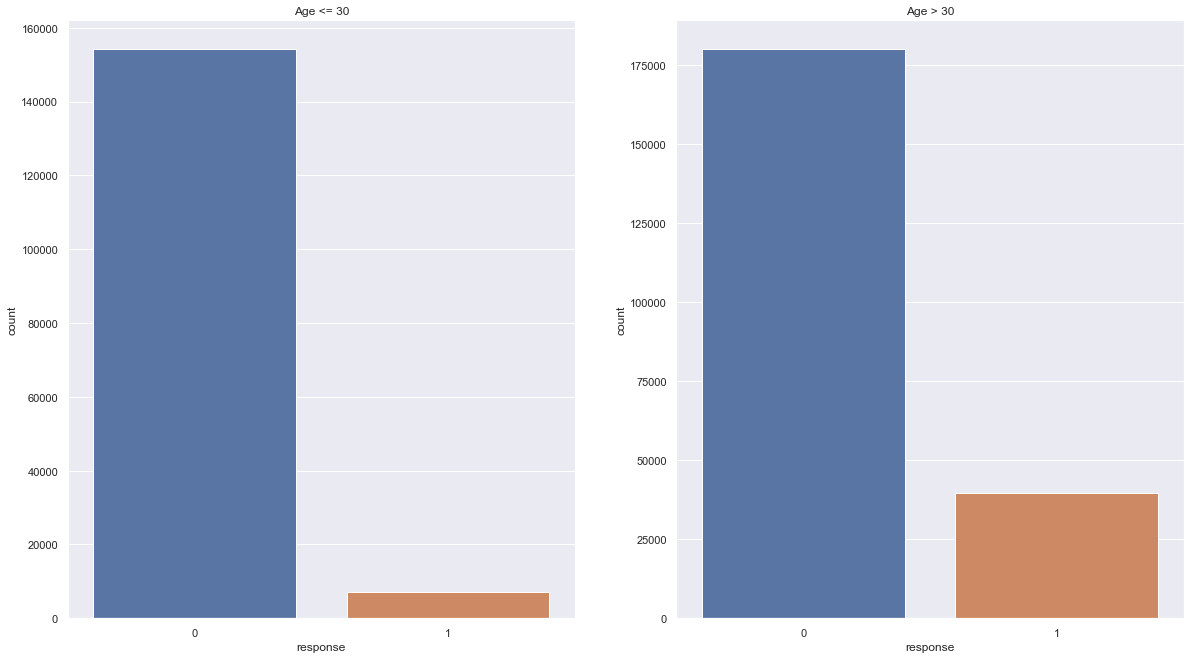

In [31]:
plt.subplot(1,2,1)
plt.title('Age <= 30')
sns.countplot(x = 'response', data = aux1);

plt.subplot(1,2,2)
plt.title('Age > 30')
sns.countplot(x = 'response', data = aux2);

### 4. Customers with older cars are less likely to want the car insurance  - False

In [32]:
df1.head().T

,0,1,2,3,4
id,7,13,18,31,39
gender,Male,Female,Female,Female,Male
age,23,41,25,26,45
region_code,11.00000,15.00000,35.00000,8.00000,8.00000
policy_sales_channel,152.00000,14.00000,152.00000,160.00000,124.00000
previously_insured,0,1,1,0,0
annual_premium,23367.00000,31409.00000,46622.00000,2630.00000,42297.00000
vintage,249,221,299,136,264
response,0,0,0,0,0
driving_license,1,1,1,1,1


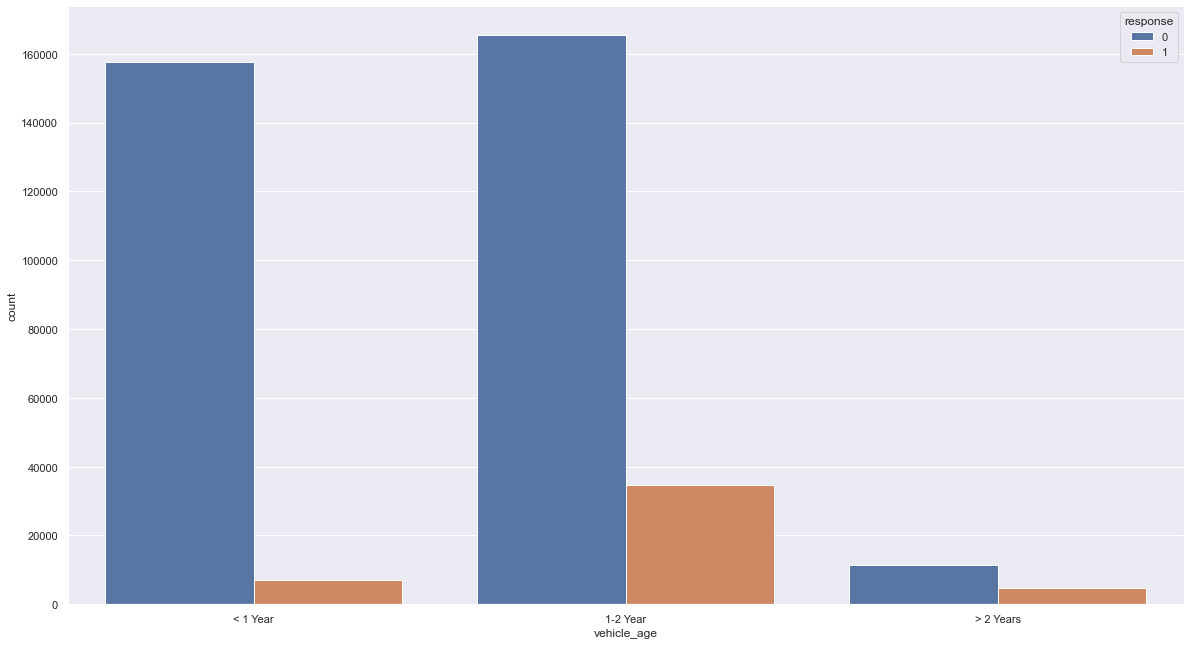

In [33]:
aux1 = df1[['vehicle_age', 'response']].groupby('vehicle_age').count().reset_index()
sns.countplot(x = 'vehicle_age', hue = 'response', data = df1);

### 5. Women are most likely to want a vehicle insurance - False

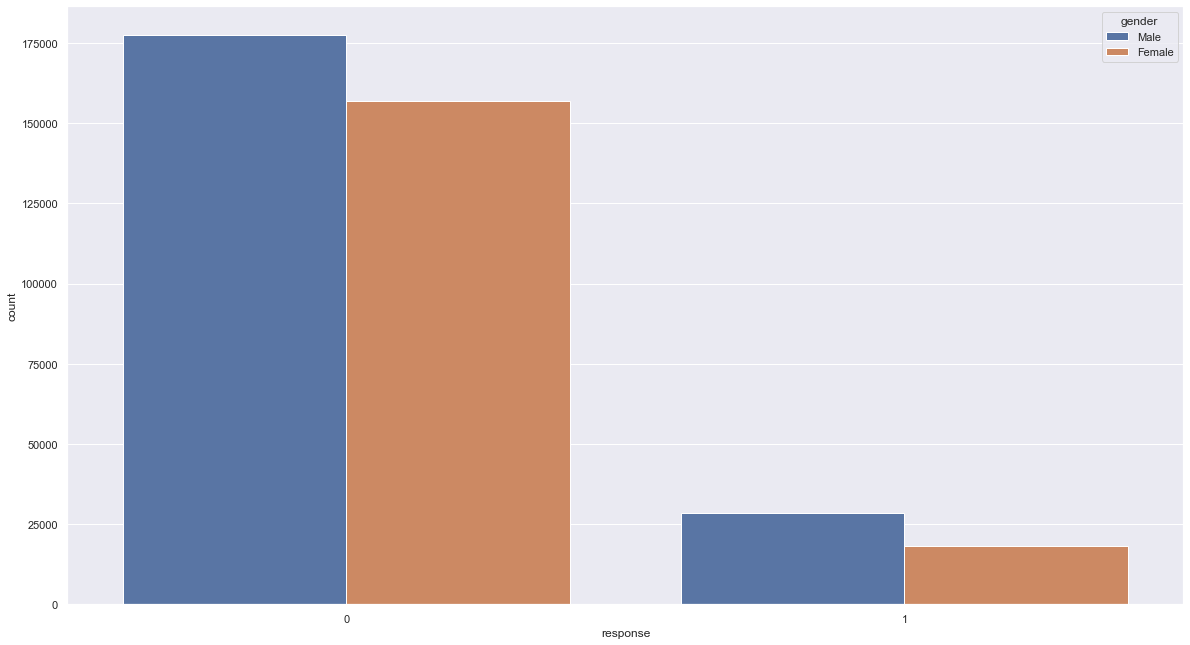

In [34]:
sns.countplot(x = 'response', hue = 'gender', data = df1);

### 6. People with +40k annual premium should want the insurance - False

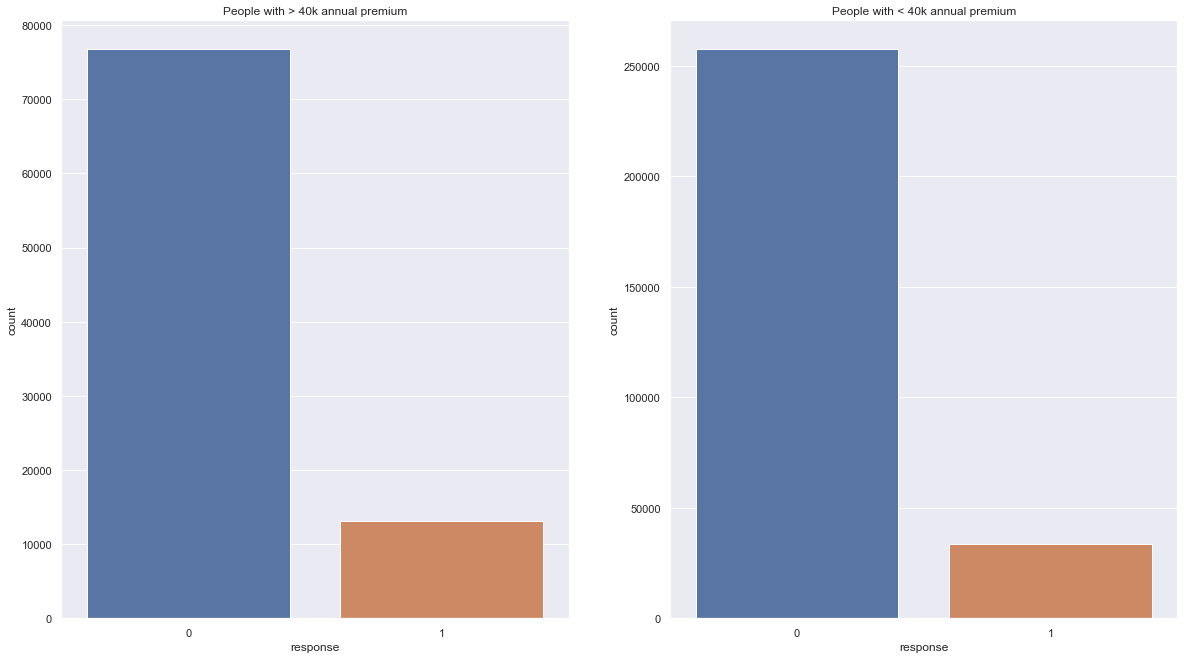

In [35]:
aux1 = df4[df4['annual_premium']> 40000]
aux2 = df4[df4['annual_premium'] <= 40000]

plt.subplot(1,2,1)
plt.title('People with > 40k annual premium')
sns.countplot(x = 'response', data = aux1);



plt.subplot(1,2,2)
plt.title('People with < 40k annual premium')
sns.countplot(x = 'response', data = aux2);


### 7. Vehicles that suffered damage before having more chances to get a vehicle insurance - False

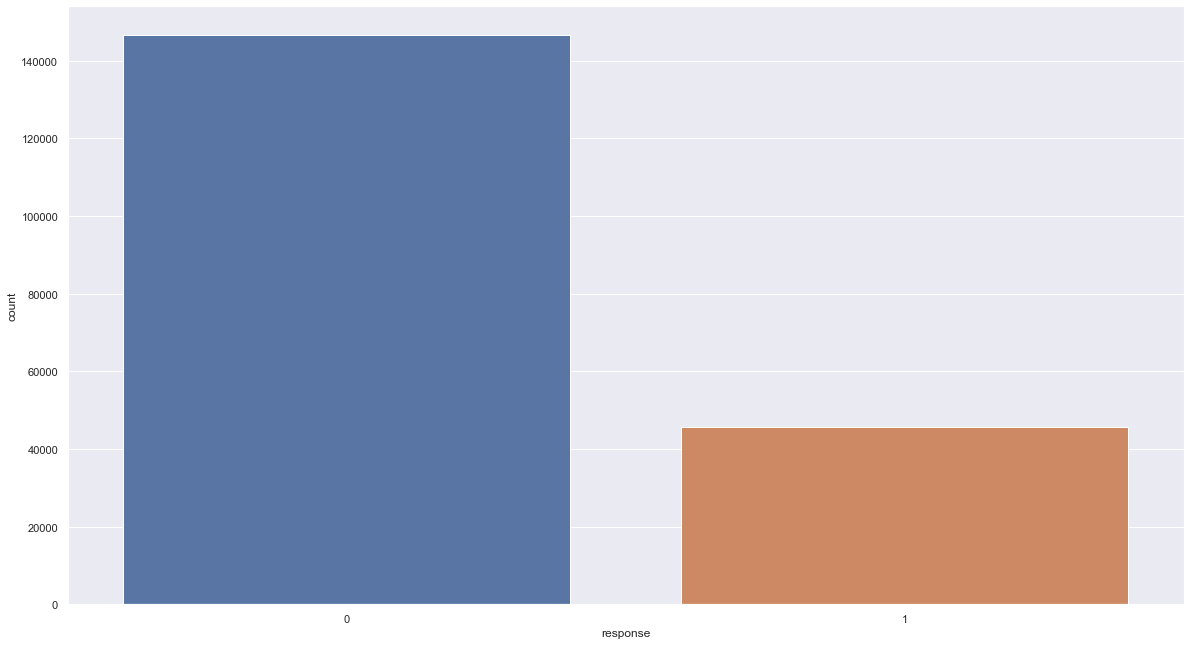

In [36]:
aux1 = df4[df4['vehicle_damage'] == 1]
sns.countplot(x = 'response', data = aux1);

## 4.3 Multivariate Analysis

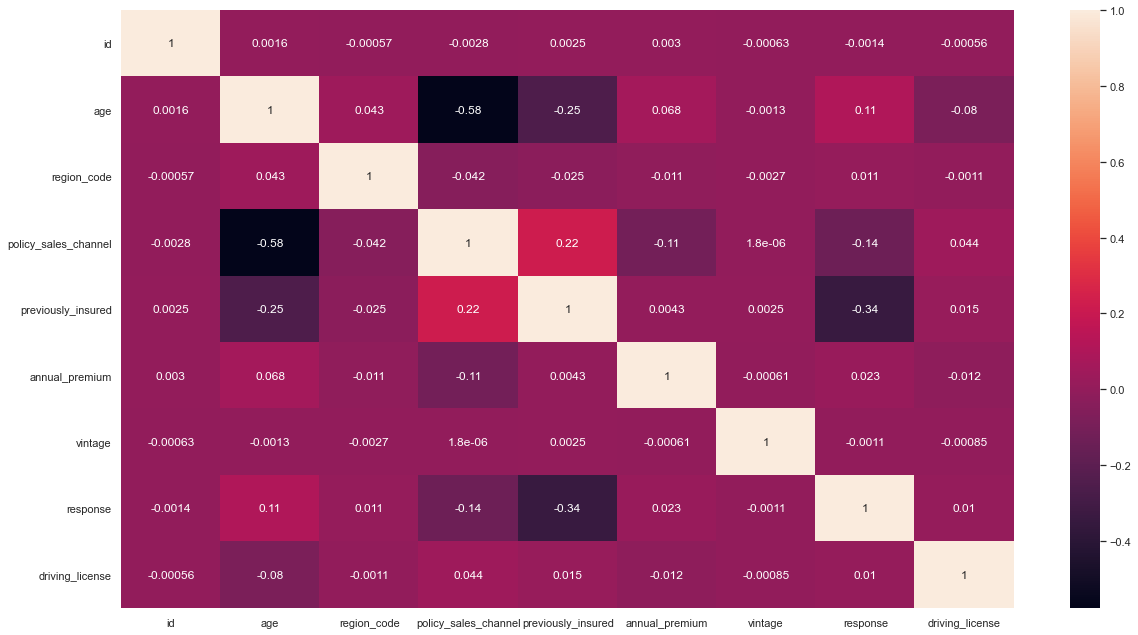

In [37]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

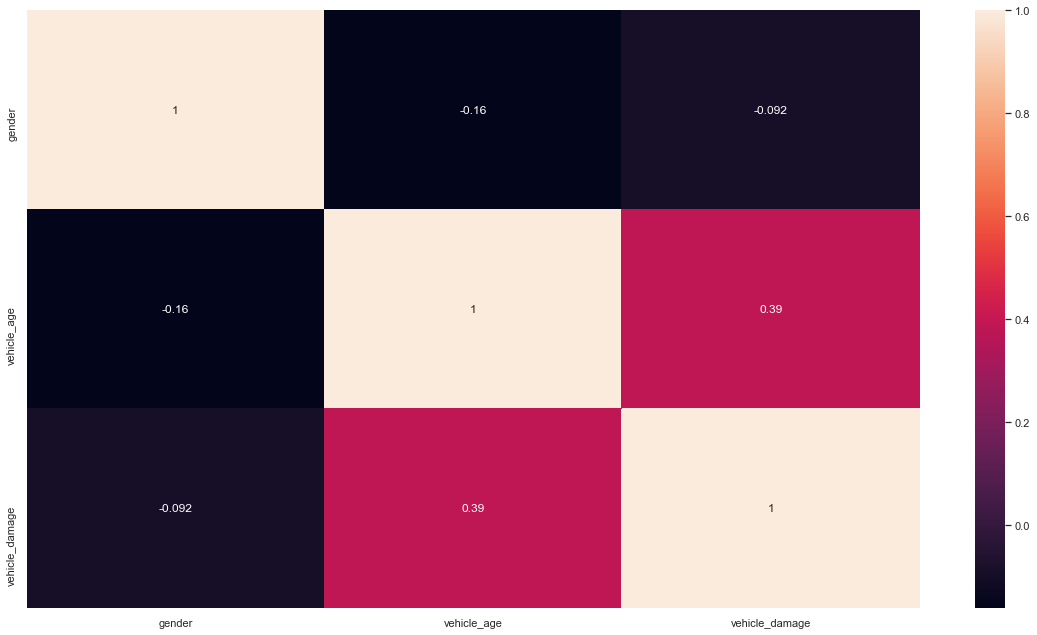

In [38]:
cat_attributes2 = df4[['gender', 'vehicle_age', 'vehicle_damage']]
sns.heatmap(cat_attributes2.corr(method = 'kendall'), annot = True);

In [39]:
num_attributes2 = df4.select_dtypes(include = ['int64', ])

In [40]:
#Id as object
df4['id'] = df4['id'].astype('object')
#Gender as bool
df4['gender'] = df4['gender'].astype(str)
#Previously 
df4['previously_insured'] = df4['gender'].astype(str)

# 5.0 Data Preparation

In [41]:
df5 = df4.copy()
df5.head().T

,0,1,2,3,4
id,7,13,18,31,39
gender,0,1,1,1,0
age,23,41,25,26,45
region_code,11.00000,15.00000,35.00000,8.00000,8.00000
policy_sales_channel,152.00000,14.00000,152.00000,160.00000,124.00000
previously_insured,0,1,1,1,0
annual_premium,23367.00000,31409.00000,46622.00000,2630.00000,42297.00000
vintage,249,221,299,136,264
response,0,0,0,0,0
driving_license,1,1,1,1,1


## 5.1 Rescaling

In [42]:
#df5['response'] = df5['response'].astype(str)
df5['driving_license'] = df5['driving_license'].astype(str)
df5['vehicle_damage'] = df5['vehicle_damage'].astype(str)
#df5['policy_sales_channel'] = df5['policy_sales_channel'].astype(str)
df5.dtypes

id                        object
gender                    object
age                        int64
region_code              float64
policy_sales_channel     float64
previously_insured        object
annual_premium           float64
vintage                    int64
response                   int64
driving_license           object
vehicle_age                int64
vehicle_damage            object
anual_premium_per_age    float64
premium_per_day          float64
dtype: object

In [43]:
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,age,region_code,policy_sales_channel,annual_premium,vintage,response,vehicle_age,anual_premium_per_age,premium_per_day
0,23,11.00000,152.00000,23367.00000,249,0,1,1015.95652,93.84337
1,41,15.00000,14.00000,31409.00000,221,0,2,766.07317,142.12217
2,25,35.00000,152.00000,46622.00000,299,0,1,1864.88000,155.92642
3,26,8.00000,160.00000,2630.00000,136,0,1,101.15385,19.33824
4,45,8.00000,124.00000,42297.00000,264,0,2,939.93333,160.21591


In [126]:
rs = RobustScaler()
mms = MinMaxScaler()

#age
df5['age'] = mms.fit_transform(df5[['age']].values)
mms_age = df5['age']
pickle.dump(mms_age, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/age_mms', 'wb'))

#vintage
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)
mms_vintage = df5['vintage']
pickle.dump(mms_vintage, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/vintage_mms', 'wb'))

#annual_premium
df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)
rs_annual_premium = df5['annual_premium']
pickle.dump(rs_annual_premium, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/annual_premium_rs', 'wb'))

#annual_premium_per_age
df5['anual_premium_per_age'] = rs.fit_transform(df5[['anual_premium_per_age']].values)
rs_annual_premium_per_age = df5['anual_premium_per_age']
pickle.dump(rs_annual_premium_per_age, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/annual_premium_per_age_rs', 'wb'))

#premium_per_day
df5['premium_per_day'] = rs.fit_transform(df5[['premium_per_day']].values)
rs_annual_premium_per_day = df5['premium_per_day'] 
pickle.dump(rs_annual_premium_per_day, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/annual_premium_per_day_rs', 'wb'))


## 5.2 Transformation

### 5.2.1 Encoding

In [127]:
#gender - Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
gender_encoding = df5['gender']
pickle.dump(gender_encoding, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/gender_encoding', 'wb') )

#region_code - Target Encoding
target_encode_region = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region)
region_encoding = df5['region_code']
pickle.dump(region_encoding, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/region_encoding', 'wb') )

In [128]:
#policy_channel - target encoding
target_encoding_channel = df5.groupby('policy_sales_channel')['response'].mean()
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(target_encoding_channel)
policy_sales_encoding = df5['policy_sales_channel']
pickle.dump(policy_sales_encoding, open('C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/features/policy_sales_encoding', 'wb') )

# 6.0 Feature Selection

In [47]:
df6 = df5.copy()
df6.shape

(381109, 14)

In [48]:
df6.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
policy_sales_channel     0
previously_insured       0
annual_premium           0
vintage                  0
response                 0
driving_license          0
vehicle_age              0
vehicle_damage           0
anual_premium_per_age    0
premium_per_day          0
dtype: int64

## 6.1 Split dataframe into train and test

In [49]:
X = df6.drop( 'response', axis=1 )
y = df6['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df6 = pd.concat( [x_train, y_train], axis=1 )

In [50]:
y_train.shape

(304887,)

In [51]:
x_train.shape

(304887, 13)

In [52]:
#data preparation
x_train_n = df6.drop(columns = ['id', 'response'] )
y_train_n = y_train.values 

## 6.2 Extra Trees Classifier

[0.00118191 0.11311973 0.08297299 0.09072125 0.00121025 0.12392283
 0.15573002 0.0004486  0.02030233 0.10835509 0.14179482 0.16024018]


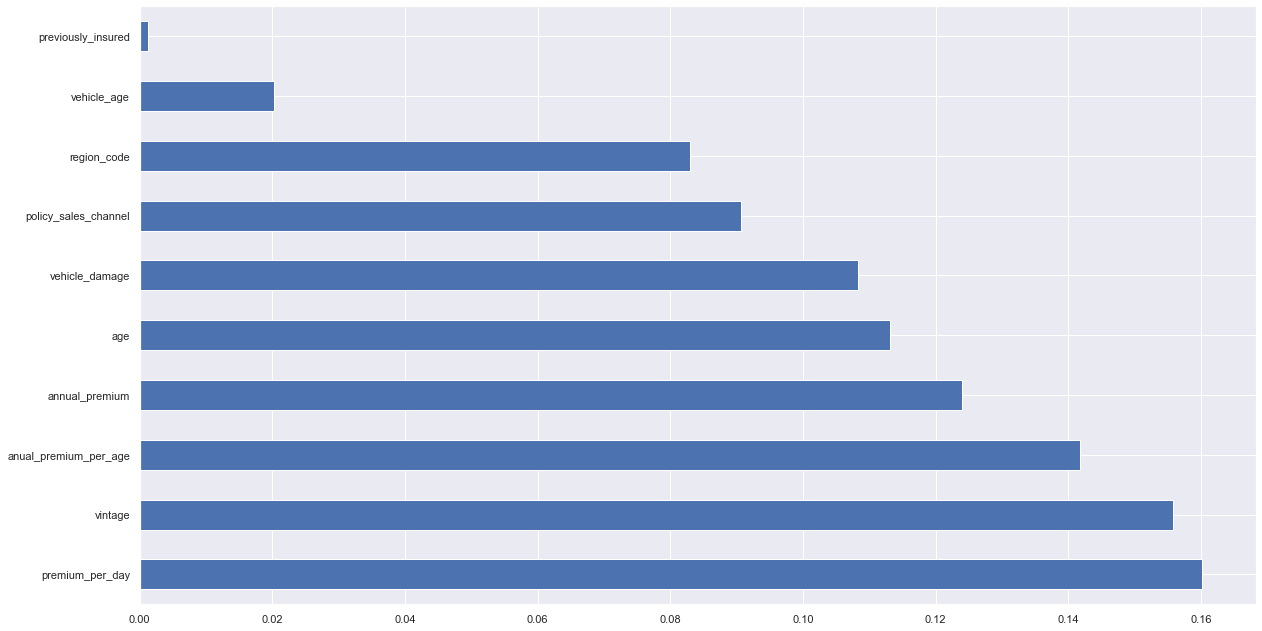

In [53]:
model = ExtraTreesClassifier()
model.fit(x_train_n, y_train_n)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x_train_n.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# 7.0 Machine Learning Modelling

In [54]:
cols_selected = ['policy_sales_channel', 'vehicle_damage', 'age', 'annual_premium', 'anual_premium_per_age', 'premium_per_day']
#Data traing 
x_train = x_train[cols_selected]

#data validation
x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1 KNN Model

In [55]:
#knn model
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [56]:
#validation - probability
y_hat_knn = knn.predict_proba(x_val)


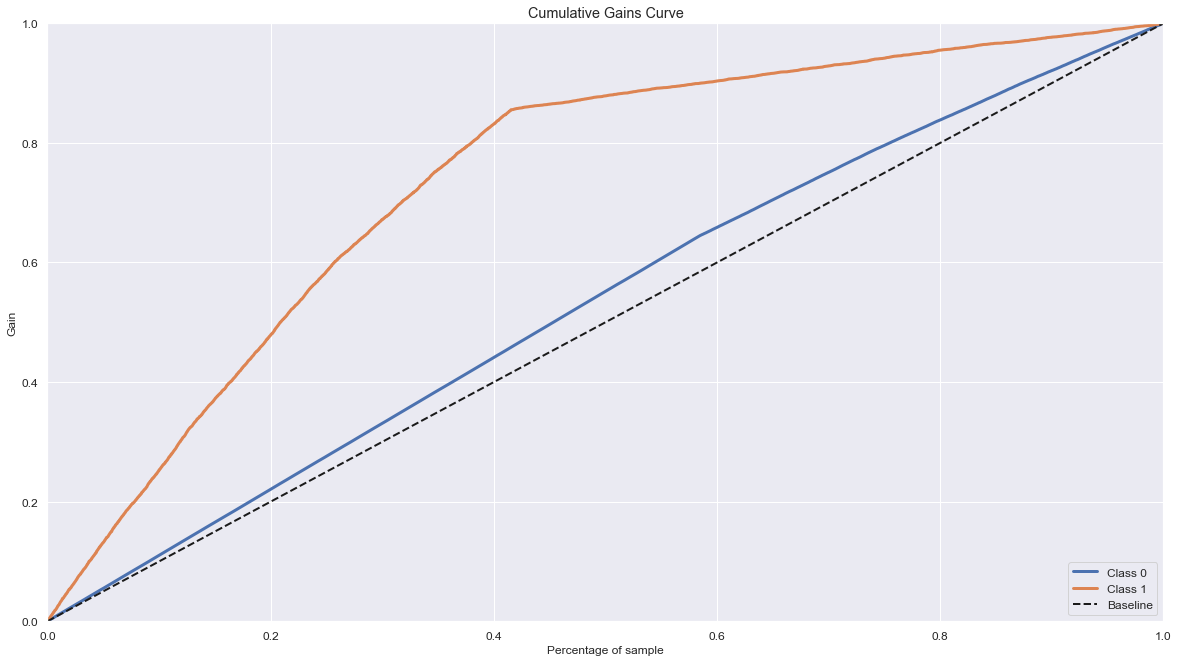

In [57]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_val, y_hat_knn);


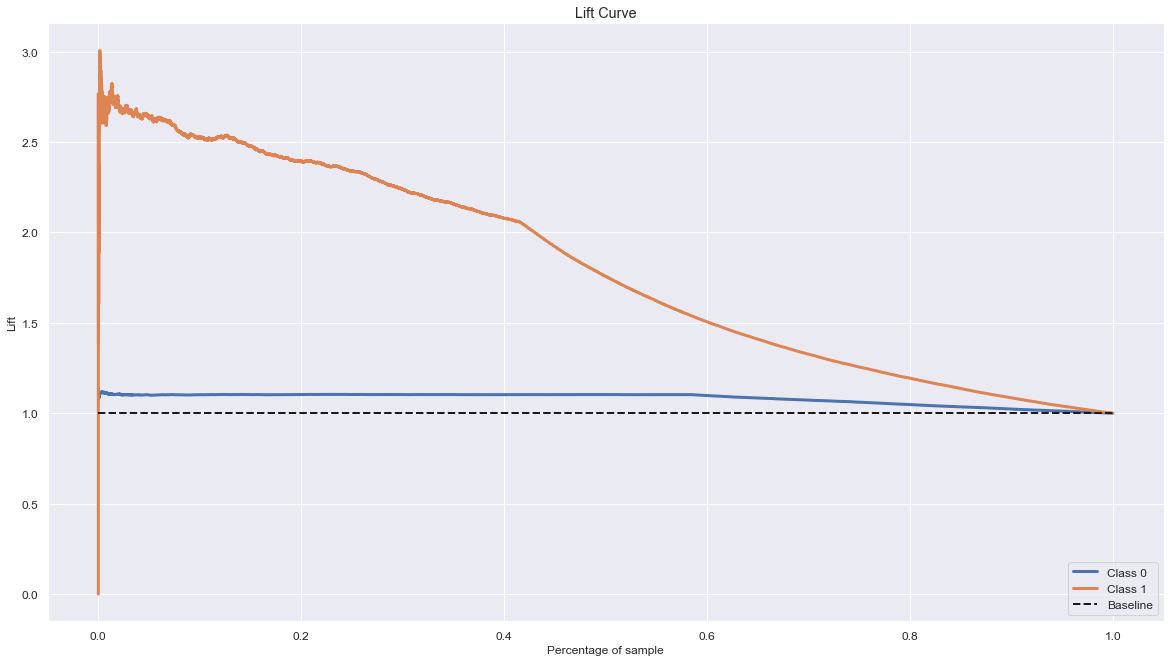

In [58]:
#Lift curve
skplt.metrics.plot_lift_curve(y_val, y_hat_knn);

## 7.2. Logistic Regression

In [59]:
#Logistic Regression Model
lg = LogisticRegression(random_state = 0)
lg.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [60]:
#validation probas
y_hat_lg = lg.predict_proba(x_val)

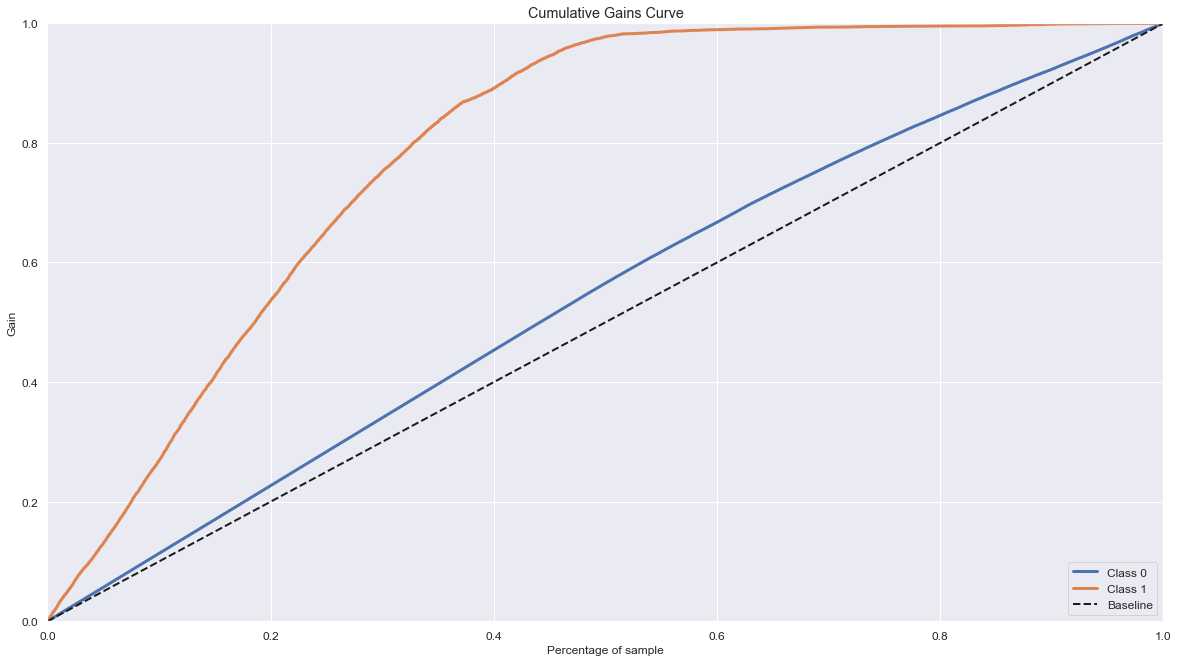

In [61]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_val, y_hat_lg);

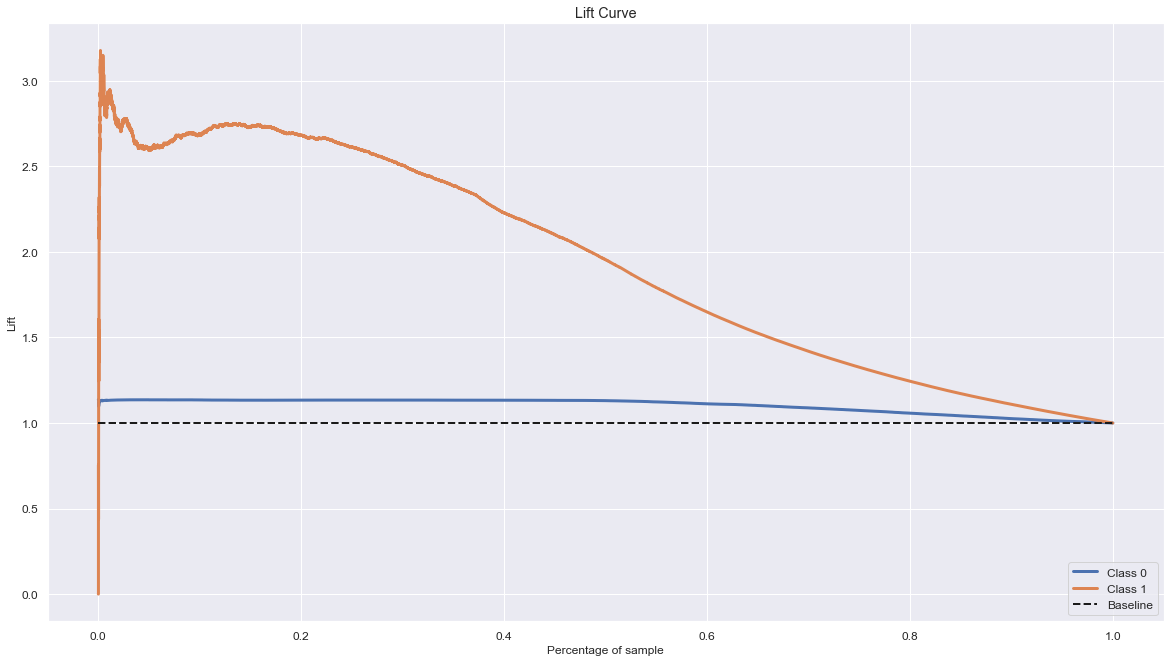

In [62]:
#lift curve 
skplt.metrics.plot_lift_curve(y_val, y_hat_lg);

## 7.3 Random Forest

In [63]:
#Random Forest train
rf = RandomForestClassifier(max_depth = 3, random_state = 0)
rf.fit(x_train, y_train)


RandomForestClassifier(max_depth=3, random_state=0)

In [64]:
#Random Forest Validation
y_hat_rf = rf.predict_proba(x_val)

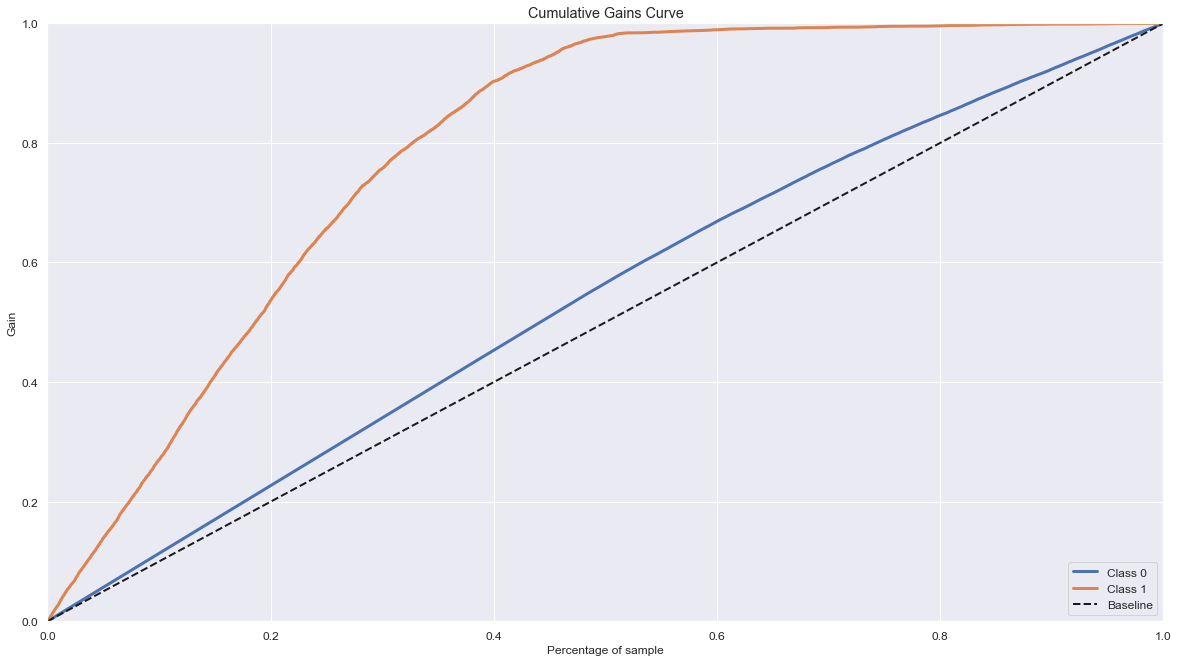

In [65]:
#Gain Cumulative curve
skplt.metrics.plot_cumulative_gain(y_val, y_hat_rf);


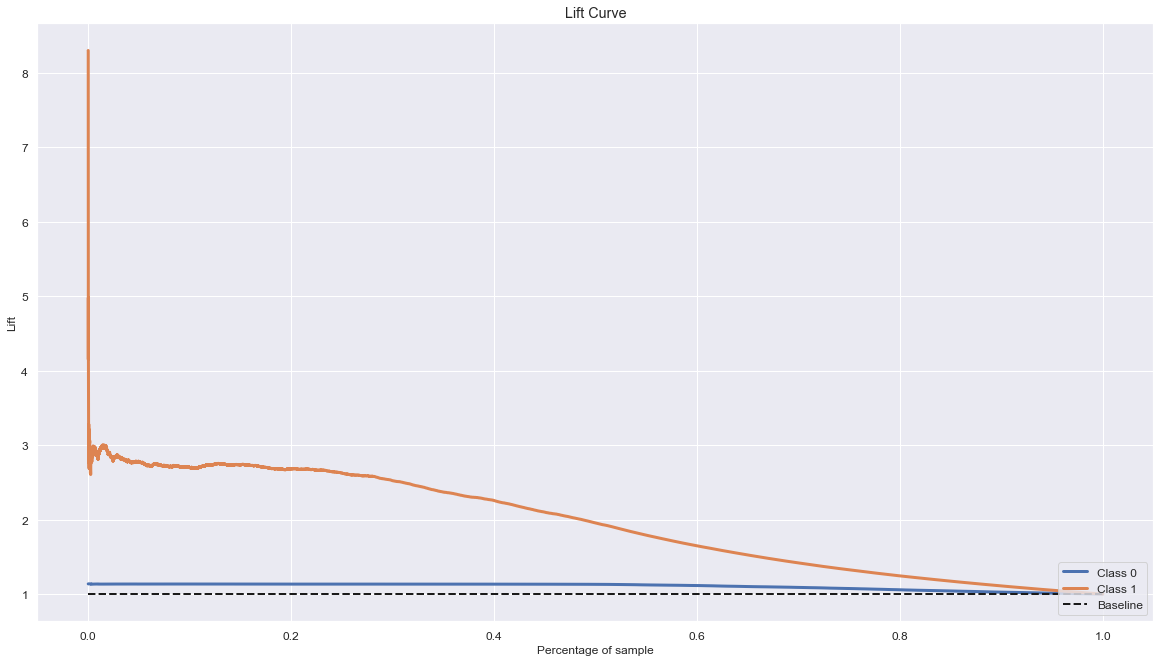

In [66]:
#lift curve
skplt.metrics.plot_lift_curve(y_val, y_hat_rf);

## 7.4 ADABoost Classifier

In [67]:
#Creating ADABoost Model
adaclf = AdaBoostClassifier()

#Train AdaboostClassifier
ada = adaclf.fit(x_train, y_train)

#Ada Validation
y_hat_ada = ada.predict_proba(x_val)

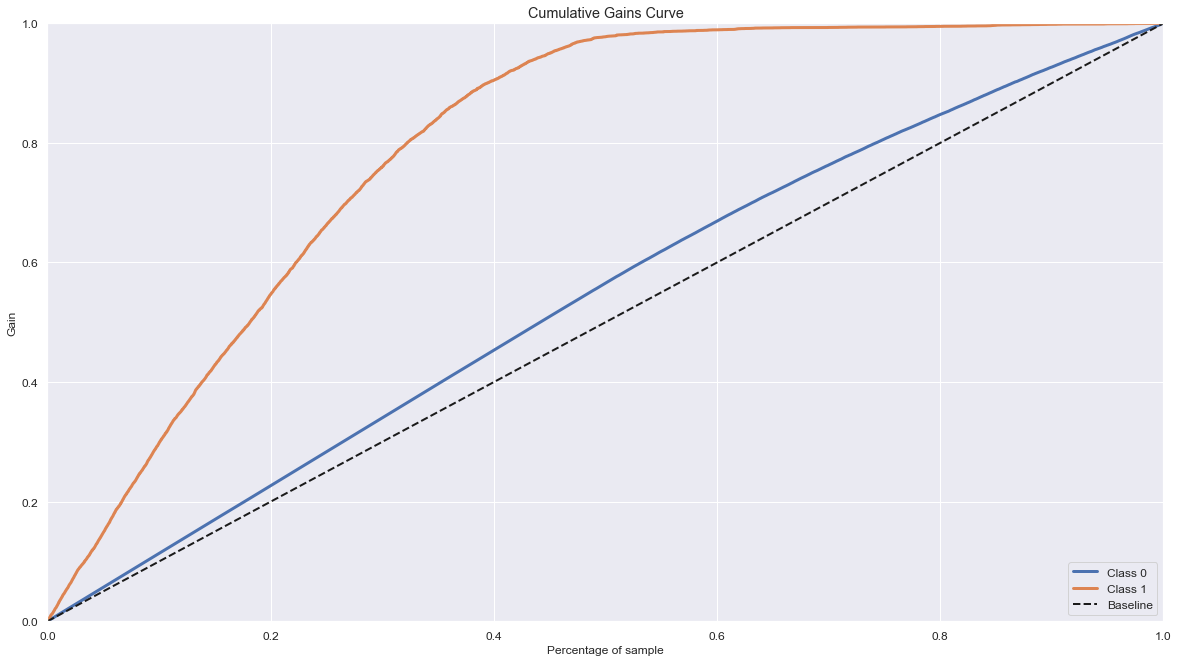

In [68]:
#Gain Curve Cumulative
skplt.metrics.plot_cumulative_gain(y_val, y_hat_ada);

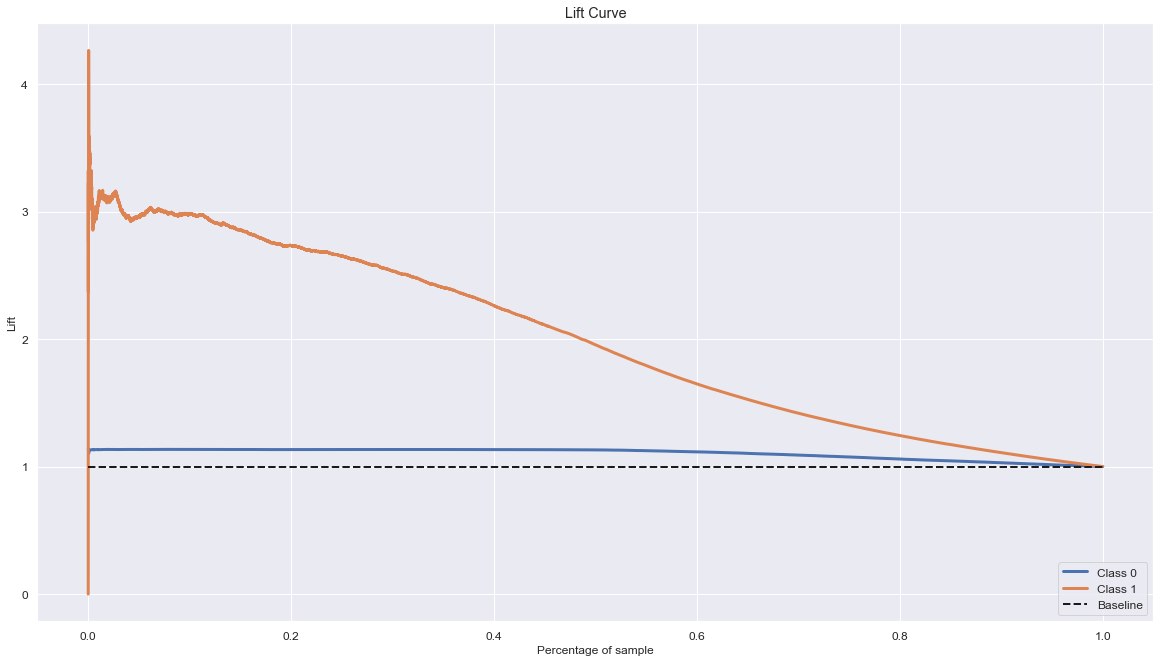

In [69]:
#lift curve
skplt.metrics.plot_lift_curve(y_val, y_hat_ada);

## 7.5 Catboost

In [70]:
#model defined
catboostclf = CatBoostClassifier(verbose = False)
#train model catboost
catboost = catboostclf.fit(x_train, y_train)
#validation model
yhat_catboost = catboost.predict_proba(x_val)

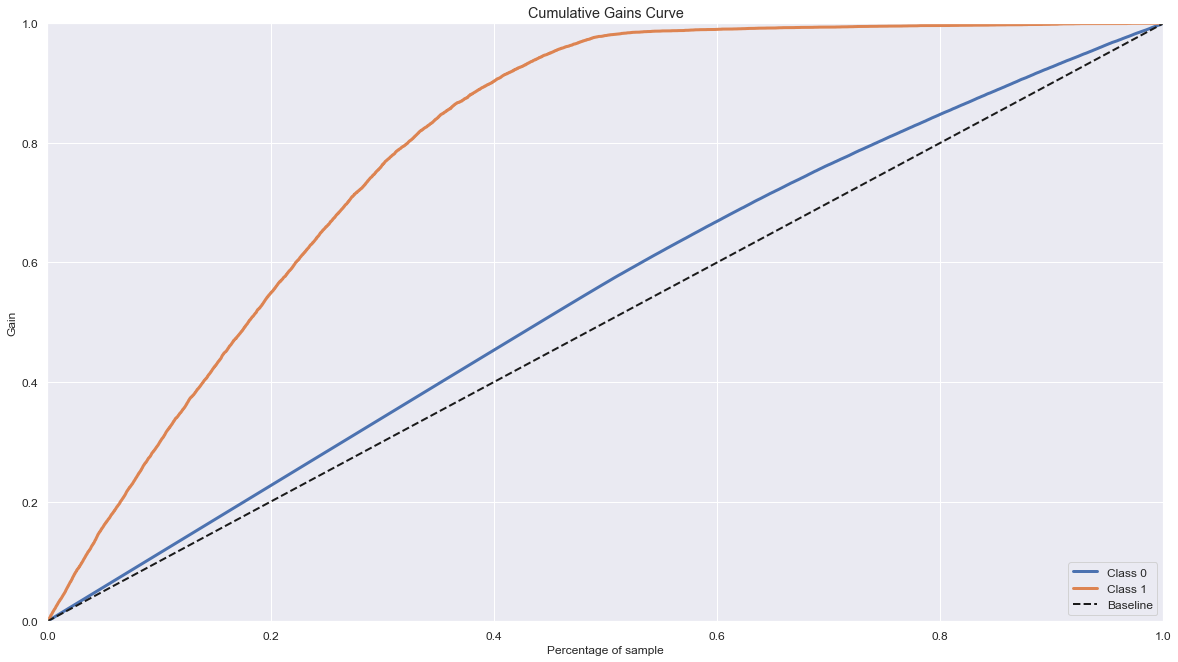

In [71]:
#gain curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_catboost);


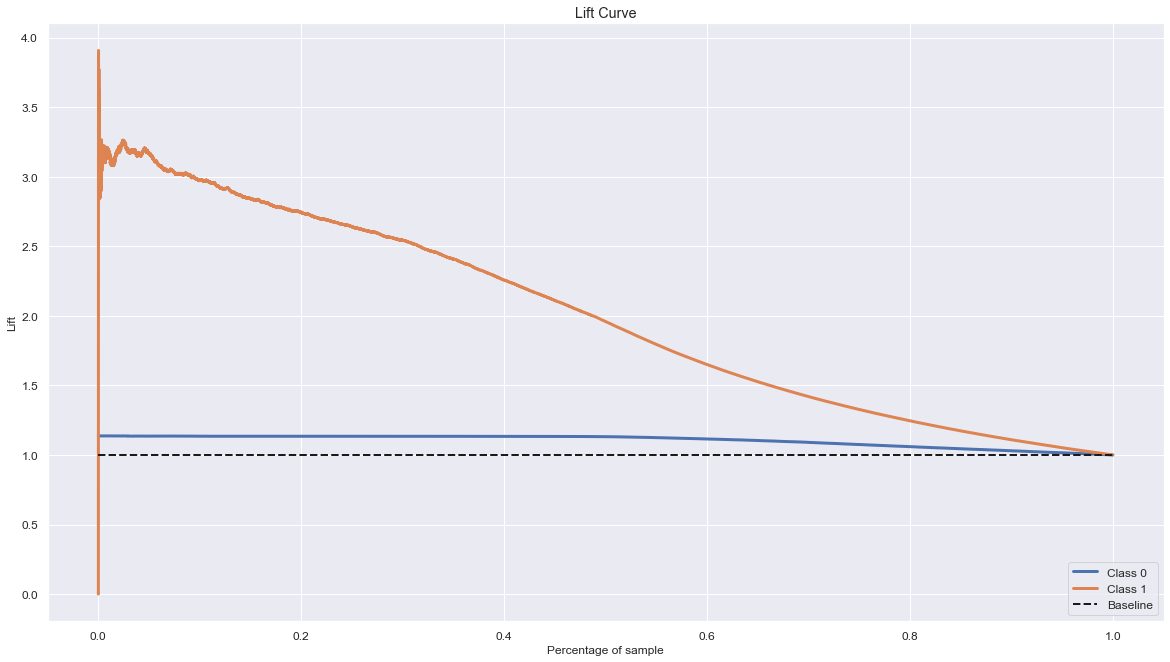

In [72]:
skplt.metrics.plot_lift_curve(y_val, yhat_catboost);

# 8.0 Model Performance

## 8.1 Cross Validation

In [73]:
knn = KNeighborsClassifier(n_jobs = -1)
lg  = LogisticRegression(random_state = 0)
rf  = RandomForestClassifier(max_depth = 3, random_state = 0)
adab= AdaBoostClassifier()
cat = CatBoostClassifier(verbose = False)
models = [knn, lg, rf, adab, cat]

In [74]:
 cross_validation(x_train, y_train, folds = 5, model =  models)

,Model,Folds,Precision @ K,Recall @ K,F1 @ K
0,KNeighborsClassifier,5,0.26635,0.64980,0.37783
1,LogisticRegression,5,0.30560,0.74555,0.43350
2,RandomForestClassifier,5,0.30902,0.75390,0.43836
3,AdaBoostClassifier,5,0.30928,0.75454,0.43873
4,CatBoostClassifier,5,0.30969,0.75553,0.43930


**We want to minimize false positives as well as possible. So in this case we'll focus on precision. **

## 8.2 AUC Roc Curve - KNN

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.771


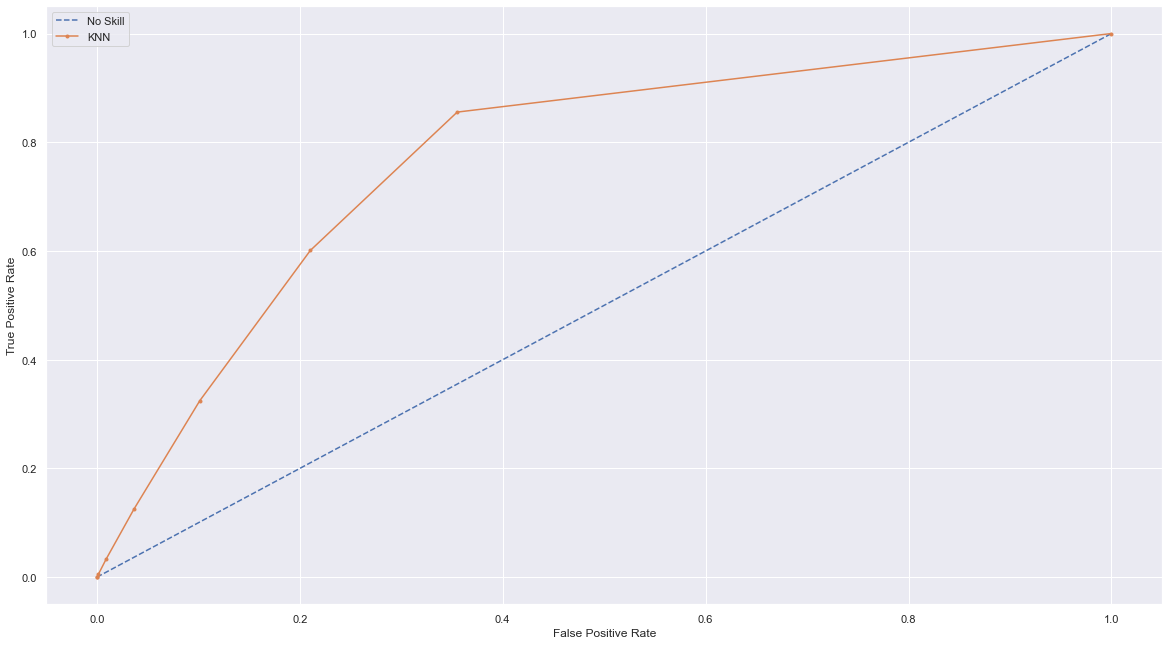

In [74]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
knn_probs = y_hat_knn[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
knn_auc = roc_auc_score(y_val, knn_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_val, knn_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 8.3 AUC Roc Curve - Logistic Regression

No Skill: ROC AUC=0.500
Lg: ROC AUC=0.833


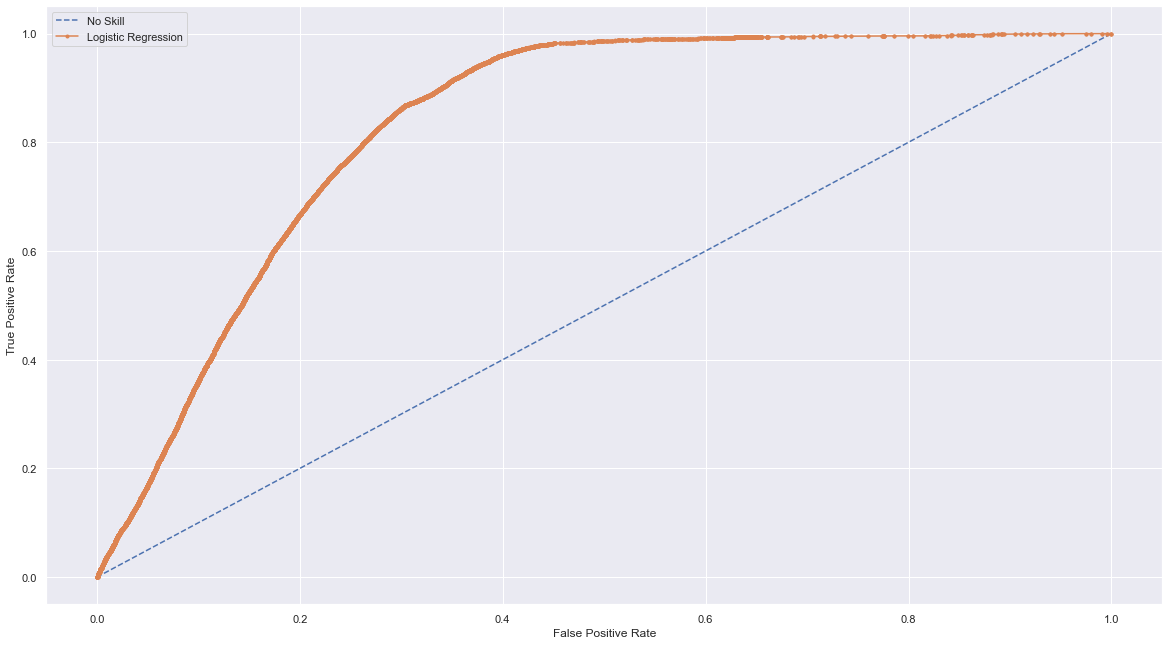

In [75]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
lg_probs = y_hat_lg[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lg_auc = roc_auc_score(y_val, lg_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Lg: ROC AUC=%.3f' % (lg_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lg_fpr, lg_tpr, _ = roc_curve(y_val, lg_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lg_fpr, lg_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [76]:
lg_probs

array([0.39302546, 0.00357219, 0.11668029, ..., 0.06370993, 0.48013281,
       0.32135317])

## 8.4 AUC Roc Curve - Random Forest

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.835


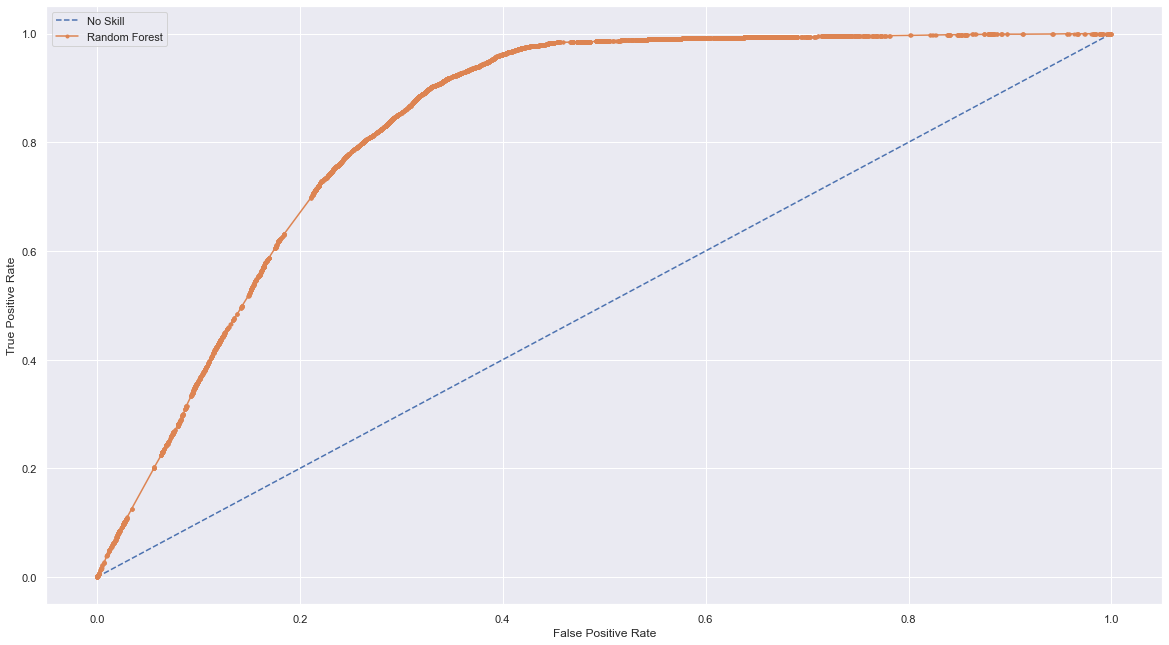

In [77]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
rf_probs = y_hat_rf[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
rf_auc = roc_auc_score(y_val, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 8.5 AUC Roc Curve - AdaBoost

No Skill: ROC AUC=0.500
AdaBoost: ROC AUC=0.840


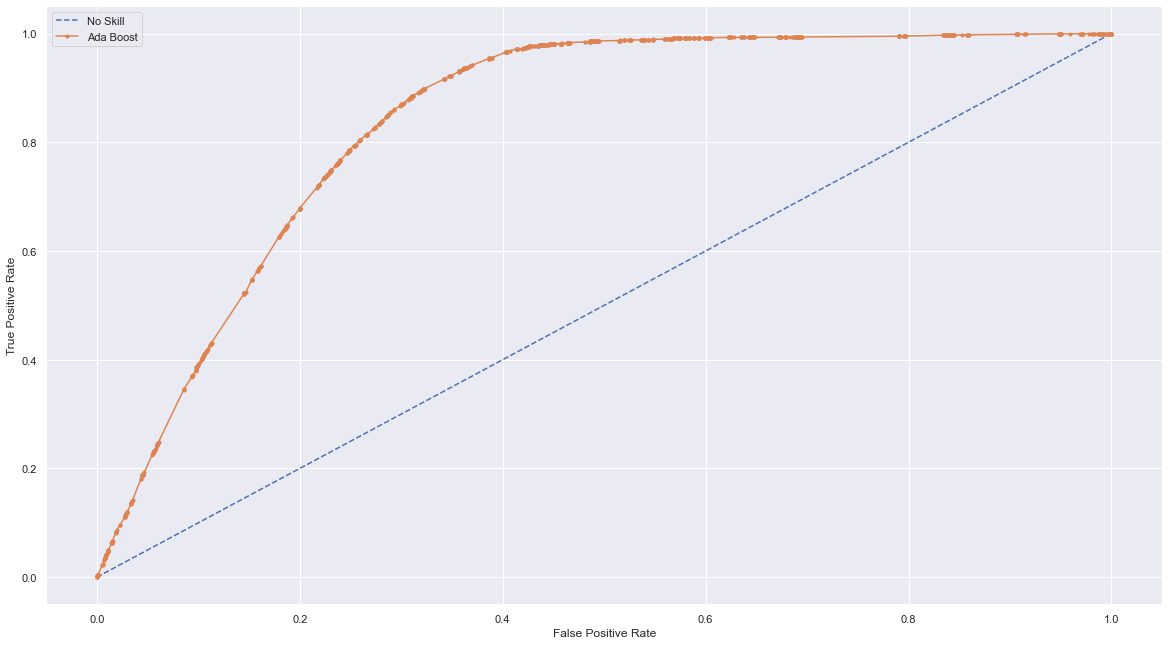

In [78]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
ada_probs = y_hat_ada[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
ada_auc = roc_auc_score(y_val, ada_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('AdaBoost: ROC AUC=%.3f' % (ada_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_val, ada_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ada_fpr, ada_tpr, marker='.', label='Ada Boost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 8.6 AUC Roc Curve - Catboost

No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.840


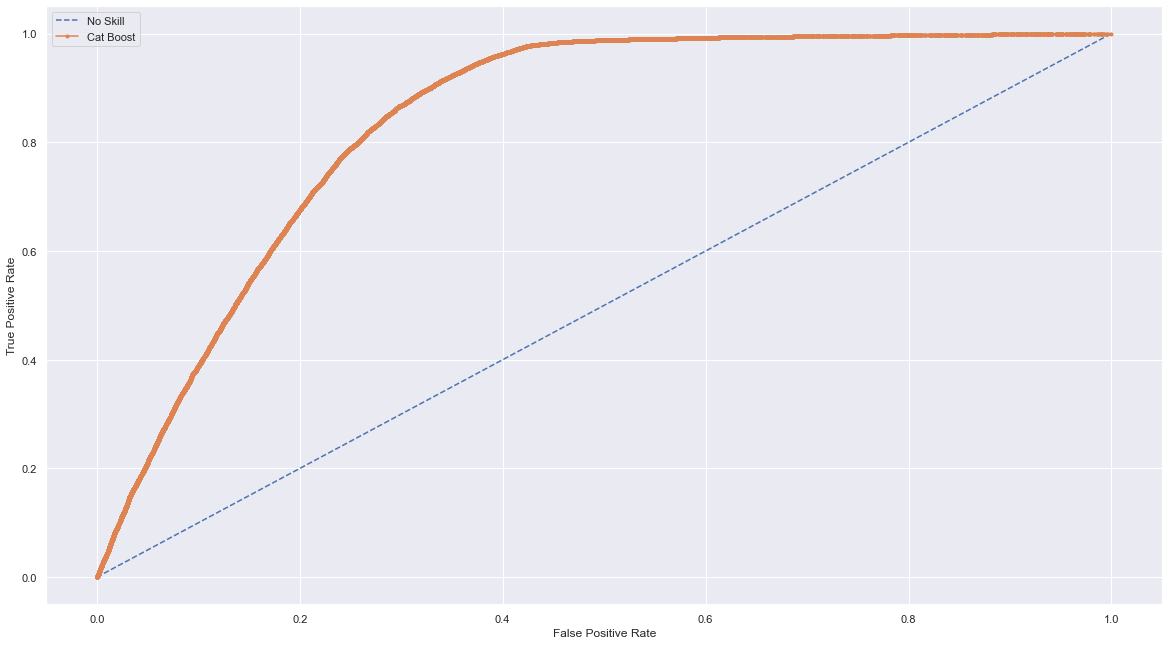

In [79]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
cat_probs = yhat_catboost[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
cat_auc = roc_auc_score(y_val, cat_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (cat_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
cat_fpr, cat_tpr, _ = roc_curve(y_val, cat_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(cat_fpr, cat_tpr, marker='.', label='Cat Boost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# 9.0 Hyperparameter Fune Tuning

**We saw that catboost model were the best model in terms of predict true positives and minimize false positives; **

In [80]:
df9 = df6.copy()

## 9.1 Catboost Tuned

In [81]:
cat2 = CatBoostClassifier(loss_function='Logloss')

In [82]:
#grid = {'iterations': [150, 200, 250],
        #'learning_rate': [0.03, 0.1],
        #'depth': [4, 6, 9],
        #'l2_leaf_reg': [1, 3, 5, 7]}

#grid_search_result = cat2.grid_search(grid, 
                                       #X=x_train, 
                                       #y=y_train, 
                                       #plot=True)

In [83]:

params_tuned = {
    'depth': 6,
    'iterations': 150,
    'learning_rate': 0.1,
    'l2_leaf_reg': 5 
}

catboostclftuned = CatBoostClassifier(depth = params_tuned['depth'],
                                    iterations = params_tuned['iterations'],
                                    learning_rate = params_tuned['learning_rate'],
                                    l2_leaf_reg = params_tuned['l2_leaf_reg'],
                                    verbose = False)

catboostclftuned = catboostclftuned.fit(x_train, y_train)
model = [catboostclftuned]
#validation model
yhat_catboosttuned = catboostclftuned.predict_proba(x_val)





In [84]:
#cross validation catboost tuned

cross_validation(x_train, y_train, 5, model)

,Model,Folds,Precision @ K,Recall @ K,F1 @ K
0,CatBoostClassifier,5,0.31268,0.76208,0.44343


## 9.2 KNN Tuned

## 9.3 Logistic Regression Tuned

In [ ]:
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import GridSearchCV
#define model
#model = LogisticRegression()
#define model parameters
#solvers = ['newton-cg', 'lbfgs', 'liblinear']
#penalty = ['l2']
#c_values = [100, 10, 1.0, 0.1, 0.01]
####define grid search
#grid = dict(solver= solvers, penalty = penalty, C= c_values)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
##grid_result = grid_search.fit(x_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
##stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [85]:
#Implementing Best Params
#define model
#lgtuned = LogisticRegression(C = 0.01, penalty = 'l2', solver = 'newton-cg')

#fit
#lgtuned = lgtuned.fit(x_train, y_train)

#validation
#yhat_lgtuned = lgtuned.predict_proba(x_val)

## 9.4 Random Forest Tuned

In [ ]:
# define dataset
#X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
#model = RandomForestClassifier()
#n_estimators = [10, 100, 1000]
#max_features = ['sqrt', 'log2']
## define grid search
#grid = dict(n_estimators=n_estimators,max_features=max_features)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#grid_result = grid_search.fit(x_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

# 10. Deploy to production

## 10.1 Define Class

In [119]:
# Save Trained Model
pickle.dump( catboostclftuned, open( 'C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/health_insurance_model2.pkl', 'wb' ) )

## 10.2 Health Insurance Class


In [152]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    def __init__( self ):
            self.home_path                      = 'C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/'
            self.mms_age                        = pickle.load( open( self.home_path + 'features/mms_age.pkl', 'rb' ) )
            self.mms_vintage                    = pickle.load( open( self.home_path + 'features/mms_vintage.pkl' , 'rb') ) 
            self.rs_annual_premium              = pickle.load( open( self.home_path + 'features/rs_annual_premium.pkl', 'rb' ) ) 
            self.rs_annual_premium_per_age      = pickle.load( open( self.home_path + 'features/rs_annual_premium_per_age.pkl', 'rb' ) )
            self.rs_annual_premium_per_day      = pickle.load( open( self.home_path + 'features/rs_annual_premium_per_day.pkl', 'rb' ) )
            self.fe_policy_sales_channel_scaler = pickle.load( open( self.home_path + 'features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
            self.gender_encoding                = pickle.load( open(self.home_path  + 'features/gender_encoding.pkl', 'rb'))
            self.region_code                    = pickle.load( open(self.home_path  + 'features/region_encoding.pkl', 'rb'))
    def data_cleaning( df1 ):

        cols_drop = ['id.1', 'id.2']
        df1 = df1.drop(cols_drop, axis = 1)
        return df1
    
    def feature_engineering(df2):
        
        
        new_vehicle_damage = {'Yes': 1, 
                              'No' : 0}

        #replace
        df2['vehicle_damage'] = df2['vehicle_damage'].map(new_vehicle_damage)

        #Gender; Female = 1, Male = 0
        gender = {'Male': 0,
                  'Female': 1}
        df2['gender'] = df2['gender'].map(gender)





        # Annual_premium per age
        df2['anual_premium_per_age'] = df2['annual_premium'] / df2['age']

        #Annual_premium per insurance day

        df2['premium_per_day'] = df2['annual_premium'] / df2['vintage']


        #vehicle_age: Droping the words "<" and "Year" and replacing < 1 year as 1 year and 1-2 year as 2
        vehicle_age = {'< 1 Year': 1,
                       '1-2 Year': 2,
                        '> 2 Years': 3}
        df2['vehicle_age'] = df2['vehicle_age'].map(vehicle_age)


        return df2
    
    
    def data_preparation(df5):

        df5['driving_license'] = df5['driving_license'].astype(str)
        df5['vehicle_damage'] = df5['vehicle_damage'].astype(str)

        #age
        df5['age'] = self.mms_age.transform(df5[['age']].values)

        #vintage
        df5['vintage'] = self.mms_vintage.transform(df5[['vintage']].values)

        #annual_premium
        df5['annual_premium'] = self.rs_annual_premium.transform(df5[['annual_premium']].values)

        #annual_premium_per_age
        df5['anual_premium_per_age'] = self.rs_annual_premium_per_age.transform(df5[['anual_premium_per_age']].values)
        
        #premium_per_day
        df5['premium_per_day'] = self.rs_annual_premium_per_day.transform(df5[['premium_per_day']].values)

        ## 5.2 Transformation

        ### 5.2.1 Encoding

        #gender - Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.gender_encoding )

        #region_code - Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.region_code)

        #policy_channel - target encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        
        

        # 7.0 Machine Learning Modelling

        cols_selected = ['policy_sales_channel', 'vehicle_damage', 'age', 'annual_premium', 'anual_premium_per_age', 'premium_per_day']
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [174]:
import pickle
import pandas as pd
from flask import Flask, request, Response

# loading model
path = 'C:/Users/Joâo Victor/Desktop/Comunidade DS/pa004/'
model = pickle.load( open( path + 'health_insurance_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
                test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat
INFO:werkzeug: * Restarting with stat


SystemExit: 1

## 10.3 API Tester

In [165]:
## 9.3. API Tester
## 9.3. API Tester

import requests

# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

df_test = df_test.sample(10)

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

data

# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

Status Code 500


JSONDecodeError: Expecting value: line 1 column 1 (char 0)